# 0.1 Imports

In [178]:
import pandas as pd
import numpy as np
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from category_encoders import TargetEncoder
from fast_ml.model_development import train_valid_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,make_scorer
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder
from xgboost import XGBRegressor
from catboost              import CatBoostRegressor

## 0.1.1 Helper functions 

In [239]:
def mean_absolute_percentage_error(y, yhat):
    mask = y != 0
    return np.mean(np.abs(np.where(mask, (y - yhat) / y, 0)))

def mae_scorer(y_true, y_pred):
    return -mean_absolute_error(y_true, y_pred)  # Negativo porque cross_val_score espera escores mais altos

def mape_scorer(y_true, y_pred):
    return -np.mean(np.abs((y_true - y_pred) / y_true))

def mape_scorer(y_true, y_pred):
    mask = y_true != 0  # Cria uma máscara para evitar divisão por zero
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    if len(y_true_masked) == 0:
        # Caso não haja valores diferentes de zero, retorne 0 (ou outro valor apropriado)
        return 0.0

    return -np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked))

def rmse_scorer(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

## 0.1.2 Loading data

In [61]:
df_raw=pd.read_csv('../datasets/raw.csv')

df_raw.head(5)

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimo_noites  numero_de_reviews ultima_review  \
0  Entire home/apt    225              1                 45    2019-05-21   
1     Private room    150              3                  0           NaN   
2  Entire home/apt     89              1                270    2019-07-05   
3  Entire home/apt     80             10                  9    2018-11-19   
4  Entire home/apt    200              3                 74    2019-06-22   

   reviews_por_mes  calculado_host_listings_count  disponibilidade_365  
0             0.38                              2                  355  
1              NaN                              1                  365  
2             4.64                              1                  194  
3             0.10                              1                    0  
4             0.59                              1                  129

# 1 Data description

## 1.1 Dimensions

In [62]:
df1=df_raw.copy()

In [63]:
print(f'Number of rows:{df1.shape[0]}')
print(f'Number of cols:{df1.shape[1]}')

Number of rows:48894
Number of cols:16


## 1.2 Data types

In [64]:
df1.dtypes

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

### 1.2.2 Change types

In [65]:
df1['ultima_review'] = pd.to_datetime(df1['ultima_review'])
df1['ultima_review'].dtype

dtype('<M8[ns]')

## 1.3 Check na

In [66]:
df1.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

## 1.4 Fillout/delete na

In [67]:
# ultima_review/reviews_por_mes
aux=df1[df1['numero_de_reviews']==0]

print(len(aux))

print(aux['ultima_review'].isna().sum())
print(aux['reviews_por_mes'].isna().sum())

aux['reviews_por_mes'].unique()

# se não há reviews, ultima_review e reviews_por_mes são vazios

10052
10052
10052


array([nan])

In [68]:
# substituir todos os NA de reviews_por_mes por 0

df1['reviews_por_mes'] = np.where(df1['reviews_por_mes'].isna(), 0, df1['reviews_por_mes'])
print(df1['reviews_por_mes'].isna().sum())
print(df1['reviews_por_mes'].min())

0
0.0


In [69]:
# ultima_review será mantida com os nans por hora, talvez seja possível excluir a variável futuramente

In [70]:
# substituir as linhas com nans em nome e host_name por 'desconhecido'

cols = ['nome','host_name']
df1[cols] = np.where(df1[cols].isna(), 'desconhecido', df1[cols])

print(df1['nome'].isna().sum())
print(df1['host_name'].isna().sum())

0
0


## 1.5 Descriptive statistics

### 1.5.1 Numeric

In [71]:
desc = df1.describe().T.reset_index()
desc.columns = ['attributes', 'count', 'mean', 'min', '25%', '50%%', '75%', 'max', 'std']

desc

attributes    count                           mean  \
0                              id  48894.0                19017532.130609   
1                         host_id  48894.0                67621393.581605   
2                        latitude  48894.0                      40.728951   
3                       longitude  48894.0                     -73.952169   
4                           price  48894.0                     152.720763   
5                   minimo_noites  48894.0                       7.030085   
6               numero_de_reviews  48894.0                      23.274758   
7                   ultima_review    38842  2018-10-04 01:46:50.710055936   
8                 reviews_por_mes  48894.0                       1.090928   
9   calculado_host_listings_count  48894.0                       7.144005   
10            disponibilidade_365  48894.0                     112.776169   

                    min                  25%                 50%%  \
0                2595.0           9472370.75           19677431.5   
1                2438.0           7822736.75           30795529.0   
2              40.49979              40.6901            40.723075   
3             -74.24442            -73.98307            -73.95568   
4                   0.0                 69.0                106.0   
5                   1.0                  1.0                  3.0   
6                   0.0                  1.0                  5.0   
7   2011-03-28 00:00:00  2018-07-08 00:00:00  2019-05-19 00:00:00   
8                   0.0                 0.04                 0.37   
9                   1.0                  1.0                  1.0   
10                  0.0                  0.0                 45.0   

                    75%                  max              std  
0           29152249.25           36487245.0  10982884.048876  
1           107434423.0          274321313.0  78611176.150486  
2             40.763117             40.91306         0.054529  
3            -73.936273            -73.71299         0.046157  
4                 175.0              10000.0       240.156625  
5                   5.0               1250.0        20.510741  
6                  24.0                629.0        44.550991  
7   2019-06-23 00:00:00  2019-07-08 00:00:00              NaN  
8                  1.58                 58.5         1.597294  
9                   2.0                327.0        32.952855  
10                227.0                365.0       131.618692

### 1.5.2 Categorical

In [72]:
colunas = ['nome', 'host_name', 'bairro_group', 'bairro', 'room_type']

for coluna in colunas:
    print(f"{coluna.capitalize()}s únicos: {len(df1[coluna].unique())}")

Nomes únicos: 47905
Host_names únicos: 11453
Bairro_groups únicos: 5
Bairros únicos: 221
Room_types únicos: 3


In [73]:
fig = make_subplots(rows=1, cols=2,subplot_titles=('bairro_groups', 'room_types'))

fig.add_trace(go.Histogram(x=df1['bairro_group']),row=1, col=1)

fig.add_trace(go.Histogram(x=df1['room_type']),row=1, col=2)
fig.update_layout(showlegend=False)

fig.show()

# <s>2 Feature engineering</s>

In [74]:
df2=df1.copy()

# <s>3 Variable filtering</s>

In [75]:
df3=df2.copy()

# 4 <s>Exploratory data analysis<s/>

In [76]:
df4=df3.copy()

# 5 Data preparation

In [254]:
df5=df4.copy()

## 5.1 Train, validation, test separation

In [255]:
x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test_split(df5, 
                                                        target = 'price', 
                                                        train_size=0.8, valid_size=0.1, test_size=0.1,
                                                        random_state=42)

x_train=x_train.drop(['id','nome','host_id','host_name','calculado_host_listings_count','ultima_review'],axis=1)
x_val=x_val.drop(['id','nome','host_id','host_name','calculado_host_listings_count','ultima_review'],axis=1)
x_test=x_test.drop(['id','nome','host_id','host_name','calculado_host_listings_count','ultima_review'],axis=1)

# df5=pd.concat ([x_train, y_train], axis=1) 

print(len(x_train))
print(len(x_val))
print(len(x_test))

39115
4889
4890


## 5.2 Histograms

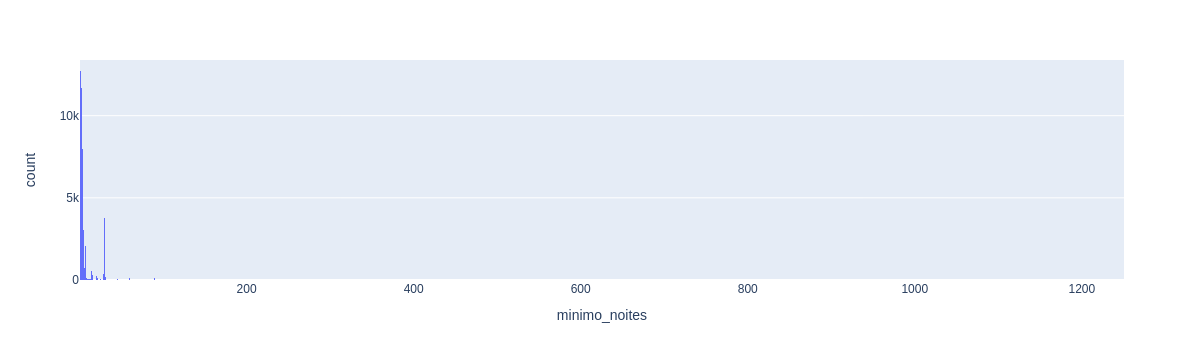

In [80]:
px.histogram(df1,x='minimo_noites')

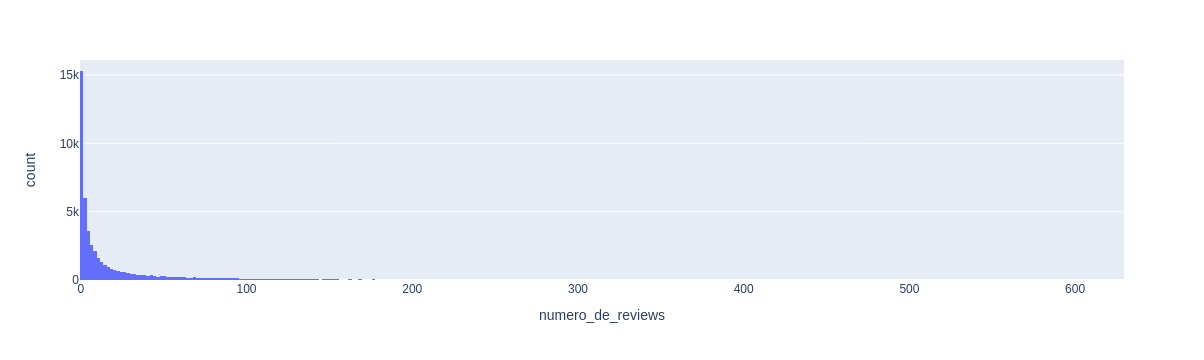

In [81]:
px.histogram(df1,x='numero_de_reviews')

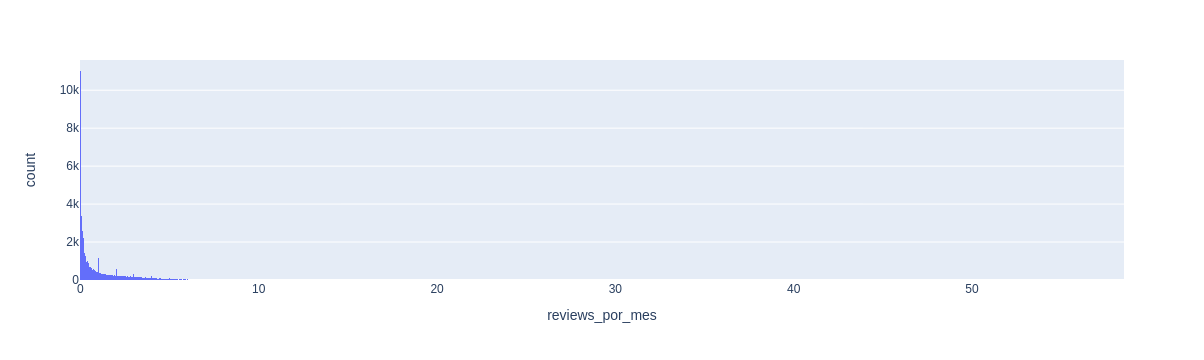

In [82]:
px.histogram(df1,x='reviews_por_mes')

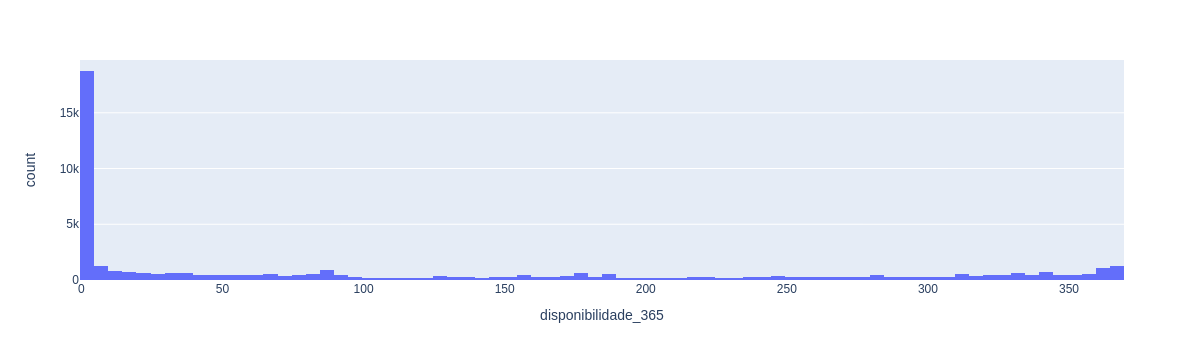

In [83]:
px.histogram(df1,x='disponibilidade_365')

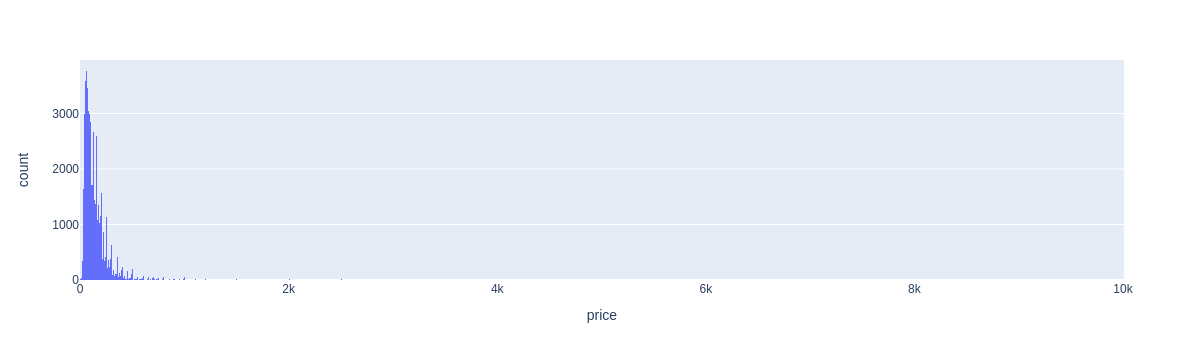

In [84]:
px.histogram(df1,x='price')

## **<s>5.3 Standardization<s/>**

## **5.4 Rescaling**

In [256]:
to_normalize = ['minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365']

scalers = {}

for var in to_normalize:
    scaler = RobustScaler()
    x_train[var] = scaler.fit_transform(x_train[[var]].values)
    x_val[var] = scaler.transform(x_val[[var]].values)
    x_test[var] = scaler.transform(x_test[[var]].values)
    scalers[var] = scaler

# rs = RobustScaler()

# y_train_array = y_train.values.reshape(-1, 1)
# y_val_array = y_val.values.reshape(-1, 1)
# y_test_array = y_test.values.reshape(-1, 1)

# y_train=rs.fit_transform(y_train_array)
# y_val=rs.transform(y_val_array)
# y_test=rs.transform(y_test_array)

## **5.5 Encoding**

In [257]:
# bairro_groups
x_train=pd.get_dummies(x_train,prefix=['bairro_group'],columns=['bairro_group'])
x_val=pd.get_dummies(x_val,prefix=['bairro_group'],columns=['bairro_group'])
x_test=pd.get_dummies(x_test,prefix=['bairro_group'],columns=['bairro_group'])

# room_type
x_train=pd.get_dummies(x_train,prefix=['room_type'],columns=['room_type'])
x_val=pd.get_dummies(x_val,prefix=['room_type'],columns=['room_type'])
x_test=pd.get_dummies(x_test,prefix=['room_type'],columns=['room_type'])

# bairro
te = TargetEncoder(cols=['bairro'])

x_train = te.fit_transform(x_train, y_train)
x_val = te.transform(x_val)
x_test = te.transform(x_test)

In [87]:
# print(x_train.isna().sum())
# print(x_val.isna().sum())
# print(x_test.isna().sum())

# **6 <s>Feature selection<s/>**

In [88]:
df6=df5.copy()

# **7 Machine Learning**

In [258]:
df7=df6.copy()

## **7.1 Average model**

In [259]:
target = df7['price']

mean_prediction = target.mean()

baseline_predictions = pd.Series([mean_prediction] * len(target))

mae_baseline = mean_absolute_error(target, baseline_predictions)
mape_baseline = mean_absolute_percentage_error(target, baseline_predictions)
rmse_baseline = np.sqrt(mse_baseline)

result_baseline = pd.DataFrame({'Model Name': 'Baseline model',
                       'MAE': mae_baseline,
                       'MAPE': mape_baseline,
                       'RMSE': rmse_baseline}, index=[0])
result_baseline

Model Name        MAE      MAPE        RMSE
0  Baseline model  92.452888  0.893024  240.154169

## **7.2 Linear regression**

In [260]:
# model
lr=LinearRegression().fit(x_train,y_train)

# prediction
lr_yhat=lr.predict(x_val)

mae_lr = mean_absolute_error(y_val, lr_yhat)
mape_lr = mean_absolute_percentage_error(y_val, lr_yhat)
mse_lr = mean_squared_error(y_val, lr_yhat)
rmse_lr = np.sqrt(mse_lr)

result_lr = pd.DataFrame({'Model Name': 'Linear Regression',
                       'MAE': mae_lr,
                       'MAPE': mape_lr,
                       'RMSE': rmse_lr}, index=[0])
result_lr

Model Name        MAE      MAPE        RMSE
0  Linear Regression  68.147196  0.507071  246.938102

### **7.2.1 Linear regression model - Cross validation** 

In [261]:
lr_cv=LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = cross_val_score(lr_cv, x_train, y_train, cv=kf, scoring=make_scorer(mae_scorer))
mape_scores = cross_val_score(lr_cv, x_train, y_train, cv=kf, scoring=make_scorer(mape_scorer))
rmse_scores = cross_val_score(lr_cv, x_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))

mae_lr_cv = np.mean(-mae_scores)
std_mae = np.std(-mae_scores)

mape_lr_cv = np.mean(-mape_scores)
std_mape = np.std(-mape_scores)

rmse_lr_cv = np.mean(-rmse_scores)
std_rmse = np.std(-rmse_scores)

result_lr_cv = pd.DataFrame({'Model Name': 'Linear regression CV',
                       'MAE': mae_lr_cv,
                       'MAPE': mape_lr_cv,
                       'RMSE': rmse_lr_cv}, index=[0])
result_lr_cv

Model Name        MAE      MAPE        RMSE
0  Linear regression CV  72.879901  0.518821  229.129303

## **7.3 Linear regression regularized**

In [262]:
# model
lrr=Lasso().fit(x_train,y_train)
 
# prediction
lrr_yhat=lrr.predict(x_val)

mae_lrr = mean_absolute_error(y_val, lrr_yhat)
mape_lrr = mean_absolute_percentage_error(y_val, lrr_yhat)
mse_lrr = mean_squared_error(y_val, lrr_yhat)
rmse_lrr = np.sqrt(mse_lrr)

result_lrr = pd.DataFrame({'Model Name': 'Lasso',
                       'MAE': mae_lrr,
                       'MAPE': mape_lrr,
                       'RMSE': rmse_lrr}, index=[0])
result_lrr

Model Name        MAE     MAPE       RMSE
0      Lasso  67.867304  0.50853  246.84757

### **7.3.1 Linear regression regularized model - Lasso**

In [263]:
lrr_cv=Lasso()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = cross_val_score(lrr_cv, x_train, y_train, cv=kf, scoring=make_scorer(mae_scorer))
mape_scores = cross_val_score(lrr_cv, x_train, y_train, cv=kf, scoring=make_scorer(mape_scorer))
rmse_scores = cross_val_score(lrr_cv, x_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))

mae_lrr_cv = np.mean(-mae_scores)
std_mae = np.std(-mae_scores)

mape_lrr_cv = np.mean(-mape_scores)
std_mape = np.std(-mape_scores)

rmse_lrr_cv = np.mean(-rmse_scores)
std_rmse = np.std(-rmse_scores)

result_lrr_cv = pd.DataFrame({'Model Name': 'Lasso CV',
                       'MAE': mae_lrr_cv,
                       'MAPE': mape_lrr_cv,
                       'RMSE': rmse_lrr_cv}, index=[0])
result_lrr_cv

Model Name        MAE      MAPE        RMSE
0   Lasso CV  72.590119  0.520795  229.249706

## **7.4 Random Forest Regressor**

In [264]:
# model
rf=RandomForestRegressor(n_jobs=-1,random_state=95).fit(x_train,y_train)

# prediction
rf_yhat=rf.predict(x_val)

mae_rf = mean_absolute_error(y_val, rf_yhat)
mape_rf = mean_absolute_percentage_error(y_val, rf_yhat)
mse_rf = mean_squared_error(y_val, rf_yhat)
rmse_rf = np.sqrt(mse_rf)

result_rf = pd.DataFrame({'Model Name': 'Random Forest',
                       'MAE': mae_rf,
                       'MAPE': mape_rf,
                       'RMSE': rmse_rf}, index=[0])
result_rf

Model Name        MAE     MAPE       RMSE
0  Random Forest  67.436844  0.45742  256.96891

### **7.4.1 Random forest regressor - Cross validation** 

In [265]:
rf_cv=RandomForestRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = cross_val_score(rf_cv, x_train, y_train, cv=kf, scoring=make_scorer(mae_scorer))
mape_scores = cross_val_score(rf_cv, x_train, y_train, cv=kf, scoring=make_scorer(mape_scorer))
rmse_scores = cross_val_score(rf_cv, x_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))

mae_rf_cv = np.mean(-mae_scores)
std_mae = np.std(-mae_scores)

mape_rf_cv = np.mean(-mape_scores)
std_mape = np.std(-mape_scores)

rmse_rf_cv = np.mean(-rmse_scores)
std_rmse = np.std(-rmse_scores)

result_rf_cv = pd.DataFrame({'Model Name': 'Random forest CV',
                       'MAE': mae_rf_cv,
                       'MAPE': mape_rf_cv,
                       'RMSE': rmse_rf_cv}, index=[0])
result_rf_cv

Model Name        MAE    MAPE        RMSE
0  Random forest CV  70.248777  0.4676  232.959589

## **7.5 XGBoost regressor**

In [266]:
xgb_model=XGBRegressor(n_jobs=-1,random_state=95).fit(x_train,y_train)

# prediction
xgb_yhat=xgb_model.predict(x_val)

mae_xgb = mean_absolute_error(y_val, xgb_yhat)
mape_xgb = mean_absolute_percentage_error(y_val, xgb_yhat)
mse_xgb = mean_squared_error(y_val, xgb_yhat)
rmse_xgb = np.sqrt(mse_xgb)

result_xgb = pd.DataFrame({'Model Name': 'XGBoost',
                       'MAE': mae_xgb,
                       'MAPE': mape_xgb,
                       'RMSE': rmse_xgb}, index=[0])
result_xgb

Model Name        MAE      MAPE        RMSE
0    XGBoost  70.350721  0.499348  264.155287

### **7.6 XGBoost regressor - Cross validation**

In [267]:
xgb_model_cv=XGBRegressor(n_jobs=-1,random_state=95)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = cross_val_score(xgb_model_cv, x_train, y_train, cv=kf, scoring=make_scorer(mae_scorer))
mape_scores = cross_val_score(xgb_model_cv, x_train, y_train, cv=kf, scoring=make_scorer(mape_scorer))
rmse_scores = cross_val_score(xgb_model_cv, x_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))

mae_xgb_cv = np.mean(-mae_scores)
std_mae = np.std(-mae_scores)

mape_xgb_cv = np.mean(-mape_scores)
std_mape = np.std(-mape_scores)

rmse_xgb_cv = np.mean(-rmse_scores)
std_rmse = np.std(-rmse_scores)

result_xgb_cv = pd.DataFrame({'Model Name': 'XGBoost CV',
                       'MAE': mae_xgb_cv,
                       'MAPE': mape_xgb_cv,
                       'RMSE': rmse_xgb_cv}, index=[0])
result_xgb_cv

Model Name        MAE      MAPE       RMSE
0  XGBoost CV  72.046662  0.491451  235.87809

## **7.6 CatBoost regressor**

In [279]:
cat=CatBoostRegressor(logging_level='Silent').fit(x_train,y_train)

# prediction
cat_yhat=cat.predict(x_val)

mae_cat = mean_absolute_error(y_val, cat_yhat)
mape_cat = mean_absolute_percentage_error(y_val, cat_yhat)
mse_cat = mean_squared_error(y_val, cat_yhat)
rmse_cat = np.sqrt(mse_cat)

result_cat = pd.DataFrame({'Model Name': 'CatBoost',
                       'MAE': mae_cat,
                       'MAPE': mape_cat,
                       'RMSE': rmse_cat}, index=[0])
result_cat

Model Name        MAE      MAPE        RMSE
0   CatBoost  64.714014  0.444058  249.963524

### **7.6.1 CatBoost regressor - Cross validation**

In [277]:
cat_cv=CatBoostRegressor(logging_level='Silent')

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = cross_val_score(cat_cv, x_train, y_train, cv=kf, scoring=make_scorer(mae_scorer))
mape_scores = cross_val_score(cat_cv, x_train, y_train, cv=kf, scoring=make_scorer(mape_scorer))
rmse_scores = cross_val_score(cat_cv, x_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))

mae_cat_cv = np.mean(-mae_scores)
std_mae = np.std(-mae_scores)

mape_cat_cv = np.mean(-mape_scores)
std_mape = np.std(-mape_scores)

rmse_cat_cv = np.mean(-rmse_scores)
std_rmse = np.std(-rmse_scores)

result_cat_cv = pd.DataFrame({'Model Name': 'CatBoost CV',
                       'MAE': mae_cat_cv,
                       'MAPE': mape_cat_cv,
                       'RMSE': rmse_cat_cv}, index=[0])
result_cat_cv

Model Name        MAE      MAPE        RMSE
0  CatBoost CV  68.521914  0.463883  227.114991

## **7.7 Compare performances**

In [275]:
modelling_result=pd.concat([result_baseline,result_lr,result_lrr,result_rf,result_xgb,result_cat])
modelling_result_cv=pd.concat([result_baseline,result_lr_cv,result_lrr_cv,result_rf_cv,result_xgb_cv,result_cat_cv])

modelling_result.sort_values('MAE',ascending=True)

Model Name        MAE      MAPE        RMSE
0           CatBoost  64.714014  0.444058  249.963524
0      Random Forest  67.436844  0.457420  256.968910
0              Lasso  67.867304  0.508530  246.847570
0  Linear Regression  68.147196  0.507071  246.938102
0            XGBoost  70.350721  0.499348  264.155287
0     Baseline model  92.452888  0.893024  240.154169

## **7.8 Compare cross-validated performances**

In [276]:
modelling_result_cv.sort_values('MAE',ascending=True)

Model Name        MAE      MAPE        RMSE
0           CatBoost CV  68.521914  0.463883  227.114991
0      Random forest CV  70.248777  0.467600  232.959589
0            XGBoost CV  72.046662  0.491451  235.878090
0              Lasso CV  72.590119  0.520795  229.249706
0  Linear regression CV  72.879901  0.518821  229.129303
0        Baseline model  92.452888  0.893024  240.154169

## **8 - Final model**

In [280]:
# prediction
cat_yhat=cat.predict(x_test)

mae_cat = mean_absolute_error(y_test, cat_yhat)
mape_cat = mean_absolute_percentage_error(y_test, cat_yhat)
mse_cat = mean_squared_error(y_test, cat_yhat)
rmse_cat = np.sqrt(mse_cat)

final_result_cat = pd.DataFrame({'Model Name': 'CatBoost',
                       'MAE': mae_cat,
                       'MAPE': mape_cat,
                       'RMSE': rmse_cat}, index=[0])
final_result_cat

Model Name        MAE      MAPE        RMSE
0   CatBoost  63.135595  0.447241  166.634858